<a href="https://colab.research.google.com/github/Muntasir2179/BERT-multiclass-emotion-classifier/blob/main/BERT_multiclass_emotion_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 38.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 26.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 36.5 MB/s eta 0:00:00


## Importing libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
import tensorflow as tf
from transformers import BertTokenizer

## Importing dataset

In [ ]:
df = pd.read_csv('Emotion Dataset (English Text).csv', index_col=0)

In [ ]:
df.head()

,text,label
serial,,
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    20000 non-null  object
 1   label   20000 non-null  object
dtypes: object(2)
memory usage: 468.8+ KB


In [ ]:
df['label'].value_counts()

joy         6761
sadness     5797
anger       2709
fear        2373
love        1641
surprise     719
Name: label, dtype: int64

<Axes: xlabel='label', ylabel='count'>

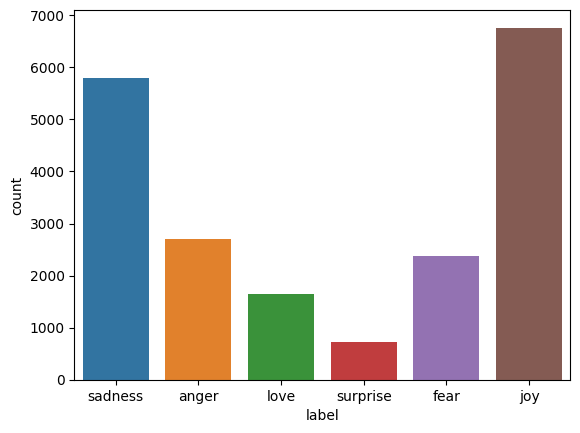

In [ ]:
sns.countplot(x='label', data=df)

## Data preparation

In [ ]:
# initializing the tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

In [ ]:
token = tokenizer.encode_plus(
    df['text'].iloc[0],
    max_length=256,
    truncation=True,
    padding='max_length',
    add_special_tokens=True,
    return_tensors='tf'
)
# special tokens refers to [CLS], [SEP], [PAD] tokens

In [ ]:
x_input_ids = np.zeros((len(df), 256))
x_attn_masks = np.zeros((len(df), 256))

In [ ]:
x_input_ids.shape

(20000, 256)

In [ ]:
def generate_training_data(df, ids, masks, tokenizer):
  for i, text in tqdm(enumerate(df['text'])):
    tokenized_text = tokenizer.encode_plus(
        text,
        max_length=256,
        truncation=True,
        padding='max_length',
        add_special_token=True,
        return_tensors='tf'
    )
    ids[i, :] = tokenized_text.input_ids  # populate all the ids for the i'th text
    masks[i, :] = tokenized_text.attention_mask  # populate all the masks for the i'th text
  return ids, masks

In [ ]:
x_input_ids, x_attn_masks = generate_training_data(df, x_input_ids, x_attn_masks, tokenizer)

Keyword arguments {'add_special_token': True} not recognized.
Keyword arguments {'add_special_token': True} not recognized.
Keyword arguments {'add_special_token': True} not recognized.
Keyword arguments {'add_special_token': True} not recognized.
Keyword arguments {'add_special_token': True} not recognized.
Keyword arguments {'add_special_token': True} not recognized.
Keyword arguments {'add_special_token': True} not recognized.
Keyword arguments {'add_special_token': True} not recognized.
Keyword arguments {'add_special_token': True} not recognized.
Keyword arguments {'add_special_token': True} not recognized.
Keyword arguments {'add_special_token': True} not recognized.
Keyword arguments {'add_special_token': True} not recognized.
Keyword arguments {'add_special_token': True} not recognized.
Keyword arguments {'add_special_token': True} not recognized.
Keyword arguments {'add_special_token': True} not recognized.
Keyword arguments {'add_special_token': True} not recognized.
Keyword 

## Applying OneHot encodeing on the labels

In [ ]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder()
labels = encoder.fit_transform((df['label'].to_numpy()).reshape(-1,1))

In [ ]:
import pickle
with open("onehot_encoder_for_BERT_multiclass_classification.pkl", "wb") as f: 
    pickle.dump(encoder, f)

In [ ]:
labels = labels.toarray()

In [ ]:
labels

array([[0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0., 0.],
       ...,
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.]])

## Creating data slices

In [ ]:
dataset = tf.data.Dataset.from_tensor_slices((x_input_ids, x_attn_masks, labels))

In [ ]:
dataset.take(1)

<_TakeDataset element_spec=(TensorSpec(shape=(256,), dtype=tf.float64, name=None), TensorSpec(shape=(256,), dtype=tf.float64, name=None), TensorSpec(shape=(6,), dtype=tf.float64, name=None))>

In [ ]:
# map function
def SentimentDatasetMapFunction(input_ids, attn_masks, labels):
  return {
      'input_ids': input_ids,
      'attention_mask': attn_masks
  }, labels

In [ ]:
dataset = dataset.map(SentimentDatasetMapFunction)

In [ ]:
dataset.take(1)

<_TakeDataset element_spec=({'input_ids': TensorSpec(shape=(256,), dtype=tf.float64, name=None), 'attention_mask': TensorSpec(shape=(256,), dtype=tf.float64, name=None)}, TensorSpec(shape=(6,), dtype=tf.float64, name=None))>

In [ ]:
dataset = dataset.shuffle(20000).batch(16, drop_remainder=True)

In [ ]:
len(dataset)

1250

In [ ]:
train_size = int((len(dataset)) * 0.8)

In [ ]:
train_size

1000

In [ ]:
train_dataset = dataset.take(train_size)
val_dataset = dataset.skip(train_size)

In [ ]:
len(train_dataset)

1000

In [ ]:
len(val_dataset)

250

## Model creation

In [ ]:
from transformers import TFBertModel

In [ ]:
bert_model = TFBertModel.from_pretrained('bert-base-cased')

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [ ]:
# input layers
input_ids = tf.keras.layers.Input(shape=(256,), name='input_ids', dtype='int32')
attention_masks = tf.keras.layers.Input(shape=(256,), name='attention_mask', dtype='int32')

In [ ]:
bert_embds = bert_model.bert(input_ids, attention_mask=attention_masks)[1]
intermediate_layer = tf.keras.layers.Dense(512, activation='relu', name='intermediate_layer')(bert_embds)
output_layer = tf.keras.layers.Dense(6, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2(0.01), name='output_layer')(intermediate_layer)

In [ ]:
model = tf.keras.Model(inputs=[input_ids, attention_masks], outputs=output_layer)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 256)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 256)]        0           []                               
                                                                                                  
 bert (TFBertMainLayer)         TFBaseModelOutputWi  108310272   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 256,                                           

In [ ]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-5,
    decay_steps=10000,
    decay_rate=1e-6)
optim = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
loss_func = tf.keras.losses.CategoricalCrossentropy()
acc = tf.keras.metrics.CategoricalAccuracy('accuracy')

In [ ]:
model.compile(optimizer=optim, loss=loss_func, metrics=[acc])

In [ ]:
hist = model.fit(
    train_dataset,
    validation_data = val_dataset,
    epochs = 5
)

Epoch 1/5
1000/1000 [==============================] - 953s 903ms/step - loss: 0.7389 - accuracy: 0.7806 - val_loss: 0.3166 - val_accuracy: 0.9283
Epoch 2/5
1000/1000 [==============================] - 897s 896ms/step - loss: 0.3377 - accuracy: 0.9172 - val_loss: 0.2638 - val_accuracy: 0.9392
Epoch 3/5
1000/1000 [==============================] - 889s 889ms/step - loss: 0.2999 - accuracy: 0.9298 - val_loss: 0.2527 - val_accuracy: 0.9405
Epoch 4/5
1000/1000 [==============================] - 889s 889ms/step - loss: 0.2961 - accuracy: 0.9290 - val_loss: 0.2563 - val_accuracy: 0.9402
Epoch 5/5
1000/1000 [==============================] - 889s 889ms/step - loss: 0.2856 - accuracy: 0.9319 - val_loss: 0.2484 - val_accuracy: 0.9417


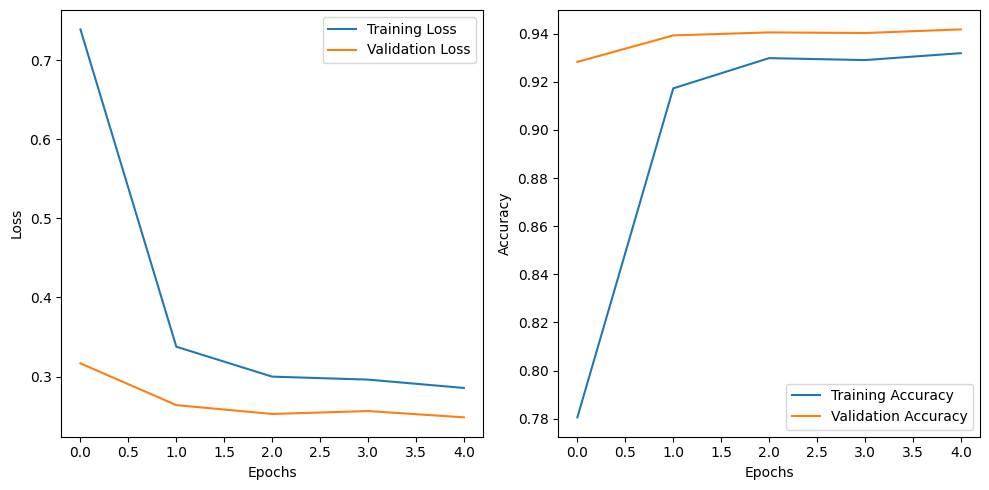

In [ ]:
# Extract training and validation metrics from history
train_loss = hist.history['loss']
val_loss = hist.history['val_loss']
train_acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']

# Plot the learning curves
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

## Saving the trained model

In [ ]:
model.save('/content/drive/MyDrive/Trained Models/bert_sentiment_classifier')

## Loading the trained model

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 30.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 29.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 108.0 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from transformers import BertTokenizer
import pickle

In [ ]:
loaded_model = tf.keras.models.load_model('/content/drive/MyDrive/Trained Models/bert_sentiment_classifier')

In [ ]:
with open('/content/drive/MyDrive/Trained Models/onehot_encoder_for_BERT_multiclass_classification.pkl', 'rb') as f:
    encoder = pickle.load(f)

In [ ]:
def get_prediction(input_text):
  tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
  # creating input ids and attention_masks of the input text
  token = tokenizer.encode_plus(
      input_text,
      max_length=256,
      truncation=True,
      padding='max_length',
      add_special_tokens=True,
      return_tensors='tf'
  )

  tokenized_input_text = {
      'input_ids': tf.cast(token.input_ids, tf.float64),
      'attention_mask': tf.cast(token.attention_mask, tf.float64)
  }

  # will give us the probability distributions of each output class
  prediction_probabilities = loaded_model.predict(tokenized_input_text)
  label = np.zeros(6)
  label[np.argmax(prediction_probabilities[0])] = 1.0
  label = encoder.inverse_transform(label.reshape(1, -1))
  return label

In [ ]:
print(get_prediction(input())[0][0])

The turbulent sea of emotions churned within her, as conflicting currents of sorrow and gratitude collided, leaving her stranded on the shores of ambivalence, where the waves of joy crashed against the cliffs of despair.
1/1 [==============================] - 0s 101ms/step
sadness


## Divide datset into 5 parts and generating prediction

In [ ]:
dataset = pd.read_csv('Emotion Dataset (English Text).csv', index_col=0)

In [ ]:
data_1 = dataset.iloc[:100, :]
data_2 = dataset.iloc[100:200, :]
data_3 = dataset.iloc[200:300, :]
data_4 = dataset.iloc[300:400, :]
data_5 = dataset.iloc[400:500, :]

print(data_1.shape)
print(data_2.shape)
print(data_3.shape)
print(data_4.shape)
print(data_5.shape)

(100, 2)
(100, 2)
(100, 2)
(100, 2)
(100, 2)


In [ ]:
# generating predictions for data_1
predictions = []
for text in data_1['text']:
  predictions.append(get_prediction(text)[0][0])

1/1 [==============================] - 0s 65ms/step


In [ ]:
predictions = pd.DataFrame(predictions, columns=['predictions'])
data_1 = pd.concat([data_1, predictions], axis=1)
data_1.head()

,text,label,predictions
0,i didnt feel humiliated,sadness,sadness
1,i can go from feeling so hopeless to so damned...,sadness,sadness
2,im grabbing a minute to post i feel greedy wrong,anger,anger
3,i am ever feeling nostalgic about the fireplac...,love,love
4,i am feeling grouchy,anger,anger


In [ ]:
match_count = 0
non_match_count = 0

for label, predictions in zip(data_1['label'], data_1['predictions']):
  if label!=predictions:
    non_match_count += 1
  else:
    match_count += 1

In [ ]:
print('Correct predictions: {}'.format(match_count))
print('Incorrect predictions: {}'.format(non_match_count))
print('The accuracy: {}'.format(match_count/len(data_1)))

Correct predictions: 97
Incorrect predictions: 3
The accuracy: 0.97


## Evaluation parameters

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report, precision_score, recall_score, f1_score

In [ ]:
y_test = data_1['label']
y_pred = data_1['predictions']
classes = dataset['label'].unique()

In [ ]:
print('Test set performance for model')
print('Accuracy score : ', accuracy_score(y_test, y_pred))
print('F1 score       : ', f1_score(y_test, y_pred, average='weighted'))
print('Precision score: ', precision_score(y_test, y_pred, average='weighted'))
print('Recall score   : ', recall_score(y_test, y_pred, average='weighted'))

Test set performance for model
Accuracy score :  0.97
F1 score       :  0.97059477124183
Precision score:  0.9732500000000001
Recall score   :  0.97


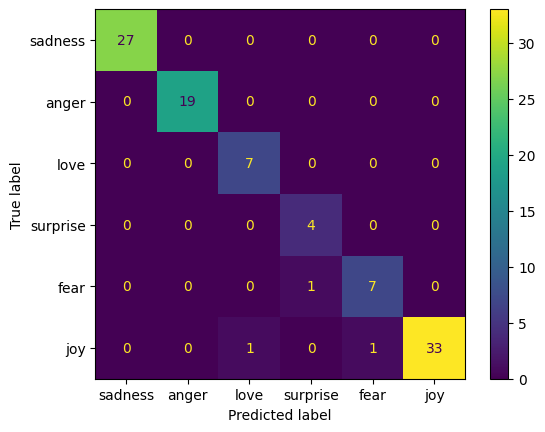

In [ ]:
# setting confusion matrix parameters
cm = confusion_matrix(y_test, y_pred, labels=classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)

# showing confusion matrix
disp.plot()
plt.show()